# Filtering and trimming messages


In [1]:
%pip install --quiet -U langchain_groq langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [5]:
llm.invoke(messages)

AIMessage(content="There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:\n\n1. **Dolphins**: Highly intelligent and social, dolphins are closely related to whales and porpoises. They're known for their playful behavior and ability to communicate with each other using clicks and whistles.\n2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life on land and in the water. They're skilled swimmers and divers, and can be found in oceans around the world.\n3. **Walruses**: With their distinctive tusks and blubbery bodies, walruses are well-suited to life in the Arctic and sub-Arctic oceans. They're skilled divers and feed on clams, mussels, and other marine animals.\n4. **Manatees**: Also known as sea cows, manatees are large, slow-moving mammals that graze on seaweed and seagrass in shallow waters. They're found in warm, coastal waters around the world.\n5. **Dugongs**: Similar to manatees, dugongs are large, herbivorous mammals 

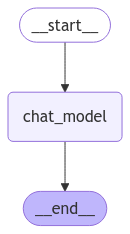

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the world and are known for their agility and playful behavior.
3. **Walruses**: With their distinctive tusks and blubbery bodies, walruses are well adapted to life in the Arctic and sub-Arctic oceans. 

## Filtering with Reducer

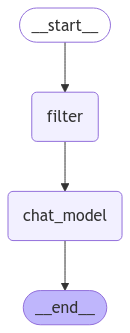

In [8]:
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState) -> MessagesState:
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the world and are known for their agility and playful behavior.
3. **Walruses**: With their distinctive tusks and blubbery bodies, walruses are well adapted to life in the Arctic and sub-Arctic oceans. 

## Filtering messages to model


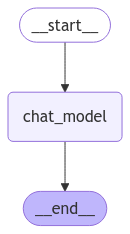

In [10]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the worl

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the worl

## Trim messages


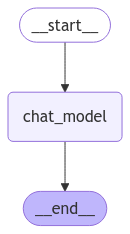

In [14]:
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [18]:
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the worl